# **MoCo: Momentum Contrast for Unsupervised Visual Representation Learning**

In [ ]:
import torch
import torch.distributions as dist
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import deque
from torch.nn import Linear, Sequential, Flatten, Module, init, CrossEntropyLoss, ReLU, BCEWithLogitsLoss
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.functional import normalize
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torch.utils.data import DataLoader , Subset
from torchvision import transforms
from torch.optim import SGD, Adam

In [ ]:
class TrainingTransforms:
    def __init__(self):
        self.transform_k = transforms.Compose(
            [
                transforms.Resize((128,128)),
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor(),
            ]
        )

    def __call__(self, inp):
        q = self.transform_k(inp)
        k = self.transform_k(inp)
        return q, k

In [ ]:
device = torch.device("cuda:5")
batch_size=64
transforms_fn = TrainingTransforms()
train_dataset = datasets.ImageFolder('/ADRL/afhq/train',transforms_fn)
test_dataset = datasets.ImageFolder('/ADRL/afhq/val',transforms_fn)
train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=batch_size)


In [ ]:
class FeatureExtractor(Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model1 = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.model2 = nn.Sequential(
            nn.Linear(4096 , 128),
            nn.LeakyReLU(),
        )


    def forward(self, x):
        return self.model2(torch.flatten(self.model1(x) , start_dim=1))

In [ ]:
def train(train_dataloader,test_dataloader,num_epochs):
    encoder_q = FeatureExtractor().to(device)
    encoder_k = FeatureExtractor().to(device)
    encoder_k.requires_grad_(False)
    optimizer = SGD(encoder_q.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    max_len = 256
    queue = deque(maxlen = max_len)
    tau = 0.07
    m = 0.999
    C = 128
    final_loss = 1e10
    for epoch in range(num_epochs):
        training_loss = 0.0
        acc = 0.0
        for batchx , batchy in tqdm(train_dataloader):
            N = batchy.shape[0]
            x_q , x_k = batchx
            x_k = x_k.to(device)
            x_q = x_q.to(device)
            q = encoder_q(x_q)
            q = normalize(q, dim=1)

            with torch.no_grad():
                k = encoder_k(x_k)
                k = normalize(k, dim=1)
            queue.append(k)

            combined_data = torch.cat(list(queue), dim=0)
            queue_t = torch.transpose(combined_data, 0, 1)
            K = combined_data.shape[0]

            tempq = q.view(N,1,C)
            tempk = k.view(N,C,1)

            l_pos = torch.bmm(q.view(N,1,C), k.view(N,C,1)).view(N,1)
            l_neg = torch.mm(q.view(N,C), queue_t)

            logits = torch.cat([l_pos, l_neg], dim=1)
            logits /= tau

            target = torch.zeros(N , dtype = torch.long).to(device)

            loss = criterion(logits, target)
            pred_class = torch.argmax(logits, dim=1)
            acc += (target == pred_class).cpu().numpy().mean()
            training_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for param_q, param_k in zip(encoder_q.parameters(), encoder_k.parameters()):
                param_k.data = param_k.data * m + param_q.data * (1. - m)

        if training_loss < final_loss:
            final_loss = training_loss
            torch.save(encoder_q.state_dict(), "q_state_dict.pth")
            torch.save(encoder_k.state_dict(), "k_state_dict.pth")

        #print(f"Epoch: {epoch}, Train Loss: {(training_loss/len(train_dataloader))}")
        current_loss = training_loss/len(train_dataloader)
        current_acc = acc/len(train_dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {current_loss} , Accuracy : {current_acc}')

train(train_dataloader,test_dataloader,200)

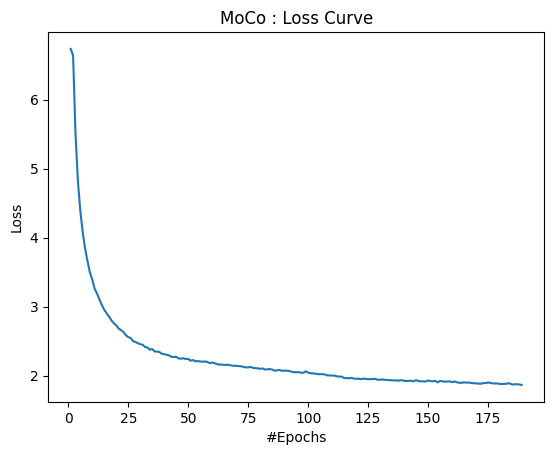

In [ ]:
Losses = [6.732912340538991, 6.6378425094238, 5.50436136295701, 4.81954217061205, 4.39077532655807, 4.0768776814489, 3.84384408684276, 3.65790640839322, 3.49574727991262, 3.391171948878525, 3.25719249821125, 3.18865354404699, 3.1019647548292, 3.021801900655421, 2.953201199202558, 2.901449087925873, 2.85475365563771, 2.799628782480564, 2.756850426894608, 2.72910327994667, 2.681598377019557, 2.65678340899371, 2.6328699567953, 2.58599473607592, 2.55796974506961, 2.5460024848255, 2.49870418044677, 2.487636246535455, 2.470009433129989, 2.4553383718932, 2.448447163969148, 2.413584672727959, 2.40795743309254, 2.37622789108076, 2.385591561096724, 2.34878496207524, 2.34966445645911, 2.341763401656171, 2.31634284939828, 2.31028475771824, 2.30127287327462, 2.293197518352858, 2.27239015529249, 2.270317776234389, 2.27219815129275, 2.24860038871848, 2.245683814760899, 2.252363495951656, 2.24032857168189, 2.24313185204585, 2.216464298260784, 2.226520861080119, 2.207401214728709, 2.211215274823284, 2.20371730098557, 2.20277998853458, 2.20471449085718, 2.197965527726052, 2.18081104859514, 2.189963672358916, 2.18005057089193, 2.16733893244547, 2.159561573157664, 2.16098834385517, 2.154737968632227, 2.155017366575882, 2.156427884726545, 2.146345247347802, 2.14174605040571, 2.14179543272376, 2.137777190541596, 2.135869761221273, 2.12593342071016, 2.119233692056747, 2.11947263172099, 2.12546028528671, 2.11367077234, 2.107674455018022, 2.106508667812597, 2.09855014111797, 2.10406356243066, 2.088406347812002, 2.091210820268855, 2.09475252930253, 2.08809917462444, 2.070938939090378, 2.077445924542356, 2.082697933938305, 2.0704660368798, 2.071158865133227, 2.07276104266987, 2.06897636063754, 2.05736803487919, 2.050988082281887, 2.048486905327, 2.05064034305805, 2.043041807595298, 2.040746678952046, 2.0625780893725, 2.043199691709993, 2.03409843361533, 2.03423555969671, 2.028704414721659, 2.0220092998321, 2.02054692772278, 2.02147877216339, 2.01658367694205, 2.003283432477426, 2.002883731538031, 2.000733306834791, 2.00125476783019, 1.988885285031847, 1.98789355067707, 1.985499278947255, 1.964654893854299, 1.96556617651443, 1.960656591377924, 1.967505520087662, 1.957904757891159, 1.954336996161781, 1.955710297068133, 1.947287635511706, 1.956921091246292, 1.952992527765998, 1.94848746451748, 1.948388160055901, 1.951729403833114, 1.952895128050225, 1.940875736386494, 1.940465143153761, 1.943964429297301, 1.938751571043089, 1.936924040057253, 1.935786702226863, 1.9348527515819, 1.92999150138755, 1.931666868222332, 1.926012453553978, 1.936997140338847, 1.92388308152361, 1.922911804315825, 1.924166642942803, 1.92590581121403, 1.918521581258315, 1.93472269424705, 1.919975268788733, 1.91845073554193, 1.9170848318583, 1.914701557575875, 1.92971678019611, 1.920629800146844, 1.9183009639057, 1.924571541719561, 1.902311072599419, 1.92245045031, 1.917850647951317, 1.912469269406847, 1.914701221291154, 1.917573089682899, 1.9049501512769, 1.915321424017827, 1.904503477192341, 1.896215690796031, 1.895683713875483, 1.902735874121886, 1.898712700110856, 1.90009503853893, 1.893656806654284, 1.889105026378381, 1.889161349384024, 1.88582026542013, 1.8811505064693, 1.89228593678453, 1.89130407285482, 1.90019207021555, 1.894782960675168, 1.88695824094214, 1.887156844659663, 1.886646356124544, 1.878502859298839, 1.88000596194288, 1.879914863661387, 1.88570561783803, 1.888375212531943, 1.872268486751739, 1.874021139727929, 1.876210705682179, 1.87171608391807, 1.865393819767314]
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array([ i for i in range(1,190)])
ypoints = np.array(Losses)

plt.title("MoCo : Loss Curve")
plt.plot(xpoints, ypoints)
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.show()

**Linear Classfier on top Pretrained Encoder_q**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp_layer =nn.Sequential(
             nn.Linear(128,3),
        )
    def forward(self,x):
        x = self.mlp_layer(x)
        return x

In [ ]:
SEED = 12345
resize_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [ ]:

def train_mlp(model_mlp,loss_fun_mlp,optimizer_mlp,encoder,train_dataloader,test_dataloader):
    num_epoch=10
    losses=[]
    accuracy=[]
    for i in range(1,num_epoch+1):
        Total_loss=0
        total_correct=0
        total_samples=0
        for xb in tqdm(train_dataloader):
            x=xb[0].to(device)
            y_true =xb[1].to(device).long()
            x = encoder(x)
            y_pred = model_mlp(x)
            loss = loss_fun_mlp(y_pred,y_true)
            optimizer_mlp.zero_grad()
            loss.backward()
            optimizer_mlp.step()
            Total_loss +=loss.item()
            y_pred = torch.argmax(y_pred,dim=1)
            total_correct += (y_pred == y_true).sum().item()
            total_samples +=y_true.size(0)
        Total_loss = Total_loss/len(train_dataloader)
        Total_accuracy = 100 * total_correct / total_samples
        losses.append(Total_loss)
        accuracy.append(Total_accuracy)
        print(f'Epoch [{i}]  Loss : {round(Total_loss,4)}  Accuracy : {round(Total_accuracy,4)}')

    test_correct=0
    test_samples=0
    for xb in tqdm(test_dataloader):
        x=xb[0].to(device)
        y_true =xb[1].to(device).long()
        x = encoder(x)
        y_pred = model_mlp(x)
        y_pred = torch.argmax(y_pred,dim=1)
        test_correct += (y_pred == y_true).sum().item()
        test_samples +=y_true.size(0)
    Test_accuracy = 100 * test_correct / test_samples
    print(f'Test Accuracy : {round(Test_accuracy,4)}')

In [ ]:
def  Encoder_MLP():
    print("Started")
    file = open("Results_Encoder_MLP.txt","w")
    final_dataset = datasets.ImageFolder('/ADRL/afhq/train', resize_transform)
    tv_indices = np.asarray(list(enumerate(final_dataset.targets)))
    size = 0.8
    for i in range(3):
        name = "\nTrain Size:" + str((i+1)*10) +"\n"
        print(name)
        file.write(name)
        train_ind, test_ind = train_test_split(tv_indices, test_size=size, stratify=tv_indices[:,1], random_state=SEED)
        train_dataset = Subset(final_dataset, train_ind[:,0])
        test_dataset = Subset(final_dataset, test_ind[:,0])
        train_dataloader = DataLoader(dataset=train_dataset,
                                    batch_size=64,shuffle=True)

        test_dataloader = DataLoader(dataset=test_dataset,
                                    batch_size=64,shuffle=True)

        size=size-0.3

        model_mlp = MLP()
        model_mlp.to(device)
        loss_fun_mlp = nn.CrossEntropyLoss()
        optimizer_mlp = torch.optim.Adam(model_mlp.parameters(),lr=1e-3)
        encoder_q = FeatureExtractor()
        encoder_q.load_state_dict(torch.load("/ADRL/q_state_dict_189.pth"))
        encoder_q.requires_grad_(False)
        encoder_q.to(device)
        train_mlp(model_mlp,loss_fun_mlp,optimizer_mlp,encoder_q,train_dataloader,test_dataloader)

In [ ]:
Encoder_MLP()

Results:


Test = [65.4135 , 66.9173 , 67.6235]


Train = [68.9679 , 70.7792  , 70.5333]

**CNN**

In [ ]:

class CNN_MLP(nn.Module):
    def __init__(self,encoder):
        super().__init__()
        self.encoder = encoder
        self.mlp_layer =nn.Sequential(
             nn.Linear(128,3),
        )
    def forward(self,x):
        x = self.encoder(x)
        x = self.mlp_layer(x)
        return x

In [ ]:

def train_cnn_mlp(model_mlp,loss_fun_mlp,optimizer_mlp,train_dataloader,test_dataloader):
    num_epoch=10
    losses=[]
    accuracy=[]
    for i in range(1,num_epoch+1):
        Total_loss=0
        total_correct=0
        total_samples=0
        for xb in tqdm(train_dataloader):
            x=xb[0].to(device)
            y_true =xb[1].to(device).long()
            y_pred = model_mlp(x)
            loss = loss_fun_mlp(y_pred,y_true)
            optimizer_mlp.zero_grad()
            loss.backward()
            optimizer_mlp.step()
            Total_loss +=loss.item()
            y_pred = torch.argmax(y_pred,dim=1)
            total_correct += (y_pred == y_true).sum().item()
            total_samples +=y_true.size(0)
        Total_loss = Total_loss/len(train_dataloader)
        Total_accuracy = 100 * total_correct / total_samples
        losses.append(Total_loss)
        accuracy.append(Total_accuracy)
        print(f'Epoch [{i}]  Loss : {round(Total_loss,4)}  Accuracy : {round(Total_accuracy,4)}')

    test_correct=0
    test_samples=0
    for xb in tqdm(test_dataloader):
        x=xb[0].to(device)
        y_true =xb[1].to(device).long()
        y_pred = model_mlp(x)
        y_pred = torch.argmax(y_pred,dim=1)
        test_correct += (y_pred == y_true).sum().item()
        test_samples +=y_true.size(0)
    Test_accuracy = 100 * test_correct / test_samples
    print(f'Test Accuracy : {round(Test_accuracy,4)}')

In [ ]:

def  Encoder_CNN_MLP():
    final_dataset = datasets.ImageFolder('/ADRL/afhq/train', resize_transform)
    tv_indices = np.asarray(list(enumerate(final_dataset.targets)))
    size = 0.8
    for i in range(3):
        name = "\nTrain Size:" + str((i+1)*10) +"\n"
        print(name)
        file.write(name)
        train_ind, test_ind = train_test_split(tv_indices, test_size=size, stratify=tv_indices[:,1], random_state=SEED)
        train_dataset = Subset(final_dataset, train_ind[:,0])
        test_dataset = Subset(final_dataset, test_ind[:,0])
        train_dataloader = DataLoader(dataset=train_dataset,
                                    batch_size=64,shuffle=True)

        test_dataloader = DataLoader(dataset=test_dataset,
                                    batch_size=64,shuffle=True)

        size=size-0.3

        encoder_q = FeatureExtractor()
        encoder_q.requires_grad_(False)
        encoder_q.to(device)
        model_mlp = CNN_MLP(encoder_q)
        model_mlp.to(device)
        loss_fun_mlp = nn.CrossEntropyLoss()
        optimizer_mlp = torch.optim.Adam(model_mlp.parameters(),lr=1e-3)
        train_cnn_mlp(model_mlp,loss_fun_mlp,optimizer_mlp,train_dataloader,test_dataloader)

Encoder_CNN_MLP()

Results :

train_acc = [56.3226 , 51.5379  , 58.1814]

test_acc= [50.7101 , 50.1794 , 55.2041]

